In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
from google.colab import files
uploaded = files.upload()


Saving augmented_labeled.csv to augmented_labeled.csv


# Transformer


In [ ]:
# @title Al-BERT + CNN
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load dataset
df = pd.read_csv("/content/augmented_labeled.csv")  # Make sure the file is uploaded to your Colab environment

# Clean and shuffle
df = df[['tweet', 'class']].dropna().sample(frac=1).reset_index(drop=True)

# Desired samples per class
samples_per_class = 3000

# Balance the dataset
df_balanced = df.groupby('class').apply(lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42)).reset_index(drop=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# One-hot encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(df_balanced['class'])
if labels.shape[1] == 1:
    labels = np.hstack([1 - labels, labels])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(df_balanced['tweet'], labels, test_size=0.1, random_state=42)

print(f"Sampled dataset size: {len(df_balanced)}")
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}")


Sampled dataset size: 9000
Train size: 8100, Val size: 900


<ipython-input-5-2262c403b55a>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class').apply(lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42)).reset_index(drop=True)



🔧 Training ALBERT + CNN
Epoch 1/10
254/254 [==============================] - 307s 1s/step - loss: 1.2267 - accuracy: 0.3540 - val_loss: 1.0530 - val_accuracy: 0.4822
Epoch 2/10
254/254 [==============================] - 280s 1s/step - loss: 1.0611 - accuracy: 0.4231 - val_loss: 0.9566 - val_accuracy: 0.5622
Epoch 3/10
254/254 [==============================] - 281s 1s/step - loss: 0.9019 - accuracy: 0.5528 - val_loss: 0.7620 - val_accuracy: 0.6522
Epoch 4/10
254/254 [==============================] - 281s 1s/step - loss: 0.7438 - accuracy: 0.6615 - val_loss: 0.6480 - val_accuracy: 0.7422
Epoch 5/10
254/254 [==============================] - 282s 1s/step - loss: 0.6050 - accuracy: 0.7507 - val_loss: 0.5942 - val_accuracy: 0.7767
Epoch 6/10
254/254 [==============================] - 280s 1s/step - loss: 0.5314 - accuracy: 0.7984 - val_loss: 0.5472 - val_accuracy: 0.8067
Epoch 7/10
254/254 [==============================] - 278s 1s/step - loss: 0.4603 - accuracy: 0.8319 - val_loss: 0.50

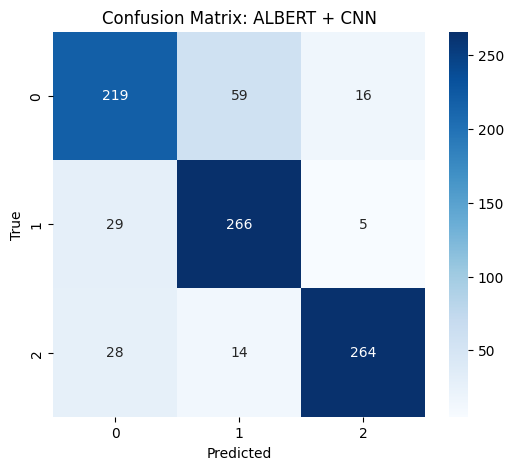

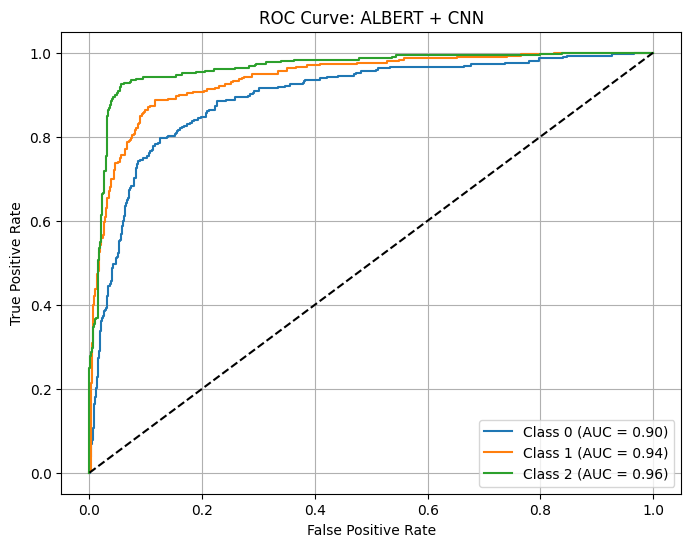

In [ ]:
# Build ALBERT + CNN model
def build_albert_cnn_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3", name='preprocessing')
    encoder_inputs = preprocessor(text_input)

    encoder = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/albert_en_base/3",  # ✅ TF2-compatible version
        trainable=True,
        name='ALBERT_encoder'
    )

    sequence_output = encoder(encoder_inputs)['sequence_output']

    x = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(sequence_output)
    x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=text_input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Train the model
print("\n🔧 Training ALBERT + CNN")

model = build_albert_cnn_model()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Predict on validation set
y_pred_probs = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Classification Report
print("\n📄 Classification Report for ALBERT + CNN")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: ALBERT + CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve (One vs Rest)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve: ALBERT + CNN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [3]:
# @title Al-BERT + MLP
import os
os.environ['TF_USE_LEGACY_KERAS']='1'

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load dataset
df = pd.read_csv("/content/augmented_labeled.csv")

# Clean and shuffle
df = df[['tweet', 'class']].dropna().sample(frac=1).reset_index(drop=True)

# Desired samples per class
samples_per_class = 3000

# Balance the dataset
df_balanced = df.groupby('class').apply(lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42)).reset_index(drop=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# One-hot encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(df_balanced['class'])
if labels.shape[1] == 1:
    labels = np.hstack([1 - labels, labels])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(df_balanced['tweet'], labels, test_size=0.1, random_state=42)

print(f"Sampled dataset size: {len(df_balanced)}")
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}")


Sampled dataset size: 9000
Train size: 8100, Val size: 900


<ipython-input-5-66d231a38239>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class').apply(lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42)).reset_index(drop=True)


In [6]:
# Build ALBERT + MLP model
def build_albert_mlp_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3", name='preprocessing')
    encoder_inputs = preprocessor(text_input)

    encoder = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/albert_en_base/3",  # TF2-compatible version
        trainable=True,
        name='ALBERT_encoder'
    )

    pooled_output = encoder(encoder_inputs)['pooled_output']

    x = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=text_input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



🔧 Training ALBERT + MLP
Epoch 1/10
254/254 [==============================] - 295s 1s/step - loss: 0.7642 - accuracy: 0.6514 - val_loss: 0.5787 - val_accuracy: 0.7611
Epoch 2/10
254/254 [==============================] - 279s 1s/step - loss: 0.4927 - accuracy: 0.8133 - val_loss: 0.4529 - val_accuracy: 0.8300
Epoch 3/10
254/254 [==============================] - 278s 1s/step - loss: 0.4009 - accuracy: 0.8536 - val_loss: 0.4156 - val_accuracy: 0.8411
Epoch 4/10
254/254 [==============================] - 279s 1s/step - loss: 0.3593 - accuracy: 0.8691 - val_loss: 0.4922 - val_accuracy: 0.8144
Epoch 5/10
254/254 [==============================] - 279s 1s/step - loss: 0.2596 - accuracy: 0.9105 - val_loss: 0.4310 - val_accuracy: 0.8678
Epoch 6/10
254/254 [==============================] - 279s 1s/step - loss: 0.1805 - accuracy: 0.9425 - val_loss: 0.4574 - val_accuracy: 0.8567
Epoch 7/10
254/254 [==============================] - 277s 1s/step - loss: 0.1616 - accuracy: 0.9472 - val_loss: 0.46

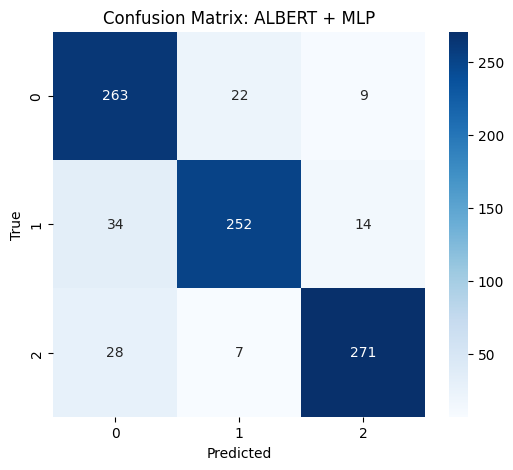

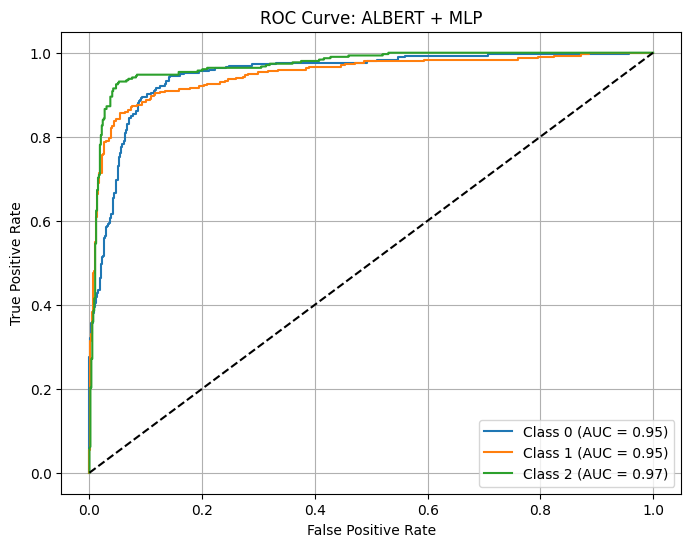

In [7]:
# Train the model
print("\n🔧 Training ALBERT + MLP")

model = build_albert_mlp_model()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Predict on validation set
y_pred_probs = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Classification Report
print("\n📄 Classification Report for ALBERT + MLP")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: ALBERT + MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve (One vs Rest)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve: ALBERT + MLP")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [10]:
# @title ELECTRA + CNN
import os
os.environ['TF_USE_LEGACY_KERAS']='1'


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Load dataset
df = pd.read_csv("/content/augmented_labeled.csv")

# Clean and shuffle
df = df[['tweet', 'class']].dropna().sample(frac=1).reset_index(drop=True)

# Desired samples per class
samples_per_class = 3000

# Balance the dataset
df_balanced = df.groupby('class').apply(lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42)).reset_index(drop=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# One-hot encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(df_balanced['class'])
if labels.shape[1] == 1:
    labels = np.hstack([1 - labels, labels])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(df_balanced['tweet'], labels, test_size=0.1, random_state=42)

print(f"Sampled dataset size: {len(df_balanced)}")
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}")


Sampled dataset size: 9000
Train size: 8100, Val size: 900


<ipython-input-11-66d231a38239>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class').apply(lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42)).reset_index(drop=True)


In [12]:
# Build ELECTRA + CNN model
def build_electra_cnn_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
    encoder_inputs = preprocessor(text_input)

    encoder = hub.KerasLayer(
        "https://tfhub.dev/google/electra_small/2",  # TF2 ELECTRA encoder
        trainable=True,
        name='ELECTRA_encoder'
    )

    sequence_output = encoder(encoder_inputs)['sequence_output']

    x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(sequence_output)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=text_input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



🔧 Training ELECTRA + CNN
Epoch 1/10
254/254 [==============================] - 117s 305ms/step - loss: 1.0950 - accuracy: 0.4091 - val_loss: 0.8658 - val_accuracy: 0.5989
Epoch 2/10
254/254 [==============================] - 77s 303ms/step - loss: 0.7080 - accuracy: 0.7074 - val_loss: 0.5679 - val_accuracy: 0.7778
Epoch 3/10
254/254 [==============================] - 79s 310ms/step - loss: 0.5414 - accuracy: 0.7998 - val_loss: 0.4841 - val_accuracy: 0.8144
Epoch 4/10
254/254 [==============================] - 76s 301ms/step - loss: 0.4703 - accuracy: 0.8357 - val_loss: 0.4607 - val_accuracy: 0.8189
Epoch 5/10
254/254 [==============================] - 76s 299ms/step - loss: 0.3942 - accuracy: 0.8636 - val_loss: 0.4557 - val_accuracy: 0.8356
Epoch 6/10
254/254 [==============================] - 76s 298ms/step - loss: 0.3497 - accuracy: 0.8852 - val_loss: 0.4340 - val_accuracy: 0.8422
Epoch 7/10
254/254 [==============================] - 76s 299ms/step - loss: 0.3040 - accuracy: 0.8965 

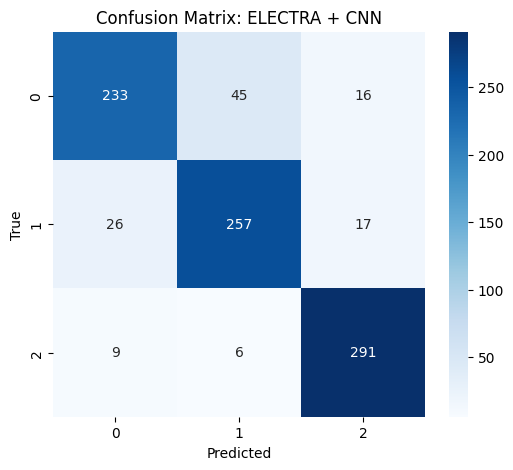

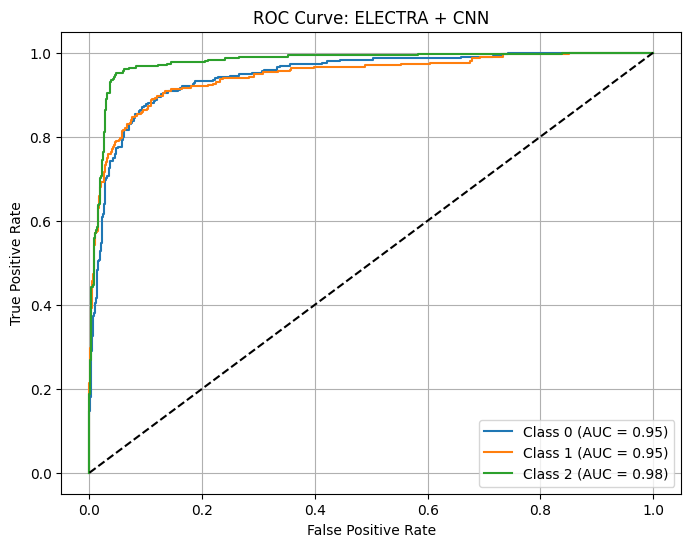

In [13]:
# Train the model
print("\n🔧 Training ELECTRA + CNN")

model = build_electra_cnn_model()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Predict on validation set
y_pred_probs = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Classification Report
print("\n📄 Classification Report for ELECTRA + CNN")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: ELECTRA + CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve (One vs Rest)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve: ELECTRA + CNN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [14]:
# @title ELECTRA + MLP
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'


In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
# Load dataset
df = pd.read_csv("/content/augmented_labeled.csv")

# Clean and shuffle
df = df[['tweet', 'class']].dropna().sample(frac=1).reset_index(drop=True)

# Balance the dataset
samples_per_class = 3000
df_balanced = df.groupby('class').apply(lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42)).reset_index(drop=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# One-hot encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(df_balanced['class'])
if labels.shape[1] == 1:
    labels = np.hstack([1 - labels, labels])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(df_balanced['tweet'], labels, test_size=0.1, random_state=42)

print(f"Sampled dataset size: {len(df_balanced)}")
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}")


Sampled dataset size: 9000
Train size: 8100, Val size: 900


<ipython-input-16-ddbbd4ac08db>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class').apply(lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42)).reset_index(drop=True)


In [19]:
# Build ELECTRA + MLP model
def build_electra_mlp_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
    encoder_inputs = preprocessor(text_input)

    encoder = hub.KerasLayer(
        "https://tfhub.dev/google/electra_small/2",
        trainable=True,
        name='ELECTRA_encoder'
    )

    pooled_output = encoder(encoder_inputs)['pooled_output']

    x = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=text_input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


🔧 Training ELECTRA + MLP
Epoch 1/10
254/254 [==============================] - 118s 318ms/step - loss: 0.9435 - accuracy: 0.5265 - val_loss: 0.6355 - val_accuracy: 0.7167
Epoch 2/10
254/254 [==============================] - 79s 312ms/step - loss: 0.6045 - accuracy: 0.7604 - val_loss: 0.4857 - val_accuracy: 0.8078
Epoch 3/10
254/254 [==============================] - 75s 297ms/step - loss: 0.4925 - accuracy: 0.8169 - val_loss: 0.4734 - val_accuracy: 0.8211
Epoch 4/10
254/254 [==============================] - 76s 297ms/step - loss: 0.4202 - accuracy: 0.8440 - val_loss: 0.4362 - val_accuracy: 0.8400
Epoch 5/10
254/254 [==============================] - 76s 297ms/step - loss: 0.3634 - accuracy: 0.8695 - val_loss: 0.4378 - val_accuracy: 0.8467
Epoch 6/10
254/254 [==============================] - 75s 297ms/step - loss: 0.3074 - accuracy: 0.8930 - val_loss: 0.4686 - val_accuracy: 0.8300
Epoch 7/10
254/254 [==============================] - 75s 296ms/step - loss: 0.2642 - accuracy: 0.9083 

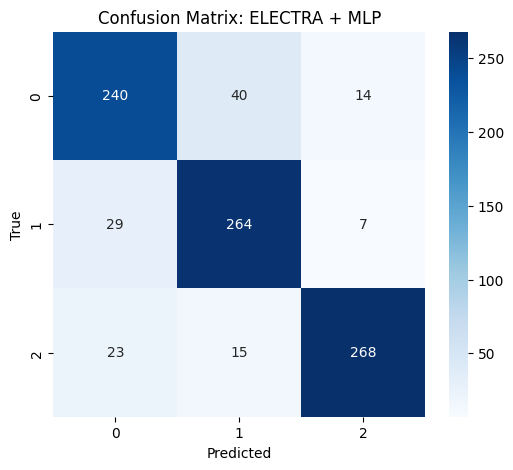

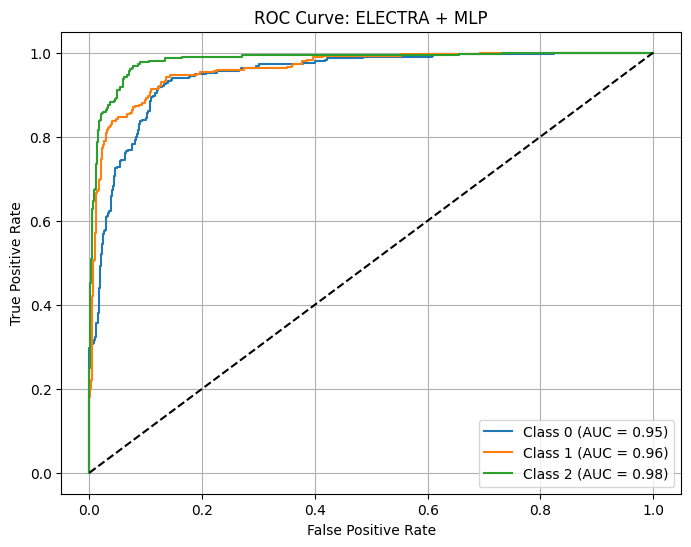

In [20]:
# Train the model
print("\n🔧 Training ELECTRA + MLP")

model = build_electra_mlp_model()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Predict on validation set
y_pred_probs = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Classification Report
print("\n📄 Classification Report for ELECTRA + MLP")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: ELECTRA + MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve (One vs Rest)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve: ELECTRA + MLP")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()